- pip install networkx
- pip install shapely
- pip install bezier
- pip install cairosvg
- pip install moviepy
- pip install matplotlib
- pip install svgpathtools

In [181]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os

import numpy as np
import math
import networkx as nx
import torch.optim as optim
import IPython.display as ipd

from deepsvg.svglib.geom import Point
from deepsvg.svglib.svg import SVG
from deepsvg.svglib.svg_path import SVGPath
from deepsvg.svglib.utils import to_gif

from deepsvg.difflib.tensor import SVGTensor
from deepsvg.difflib.utils import *
from deepsvg.difflib.loss import *

from moviepy.editor import ImageClip, concatenate_videoclips, ipython_display
from svgpathtools import svg2paths, wsvg
from PIL import Image
from shapely.geometry import Polygon
from shapely.affinity import scale

/home/ivy8792/anaconda3/envs/graph/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


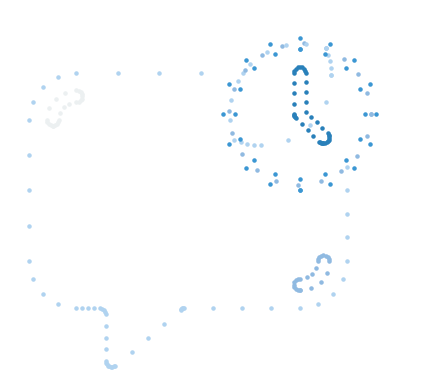

In [3]:
svg_folder = './datasets/svg'
png_folder = './datasets/png'
# colors = [plt.cm.tab20(x) for x in range(20)]

for root, folders, files in os.walk(svg_folder):
    for i, file in enumerate(files):
        if file.split('.')[1] != 'svg': continue
        if 'checkpoint' in file: continue
        
        #####
        file = "037-time.svg"
        # file = "011-library.svg"
        
        # svg_folder = './'
        # file = "sunset-2.svg"
        # file = "sunny.svg"  # fix the bug of circle
        
        file_path = os.path.join(svg_folder, file)
        svg = SVG.load_svg(file_path).normalize().zoom(0.9)  # .canonicalize().simplify_heuristic()
        svg_target, group_svg_target = svg.to_tensor()
        new_group = []
        colors = []
        for i, g in enumerate(group_svg_target):
            new_group.append(SVGTensor.from_data(g))
            colors.append(svg.colors[i])
            
        # png_name = file.replace('svg', 'png')
        # png = Image.open(os.path.join(png_folder, png_name))
        # plt.figure(figsize=(5, 3))
        # plt.subplot(121)
        # plt.title(file, fontsize=10)
        # plt.axis('off')
        # plt.imshow(png)
            
        # plt.subplot(122)
        plt.axis([0, 25, 23, 0])
        points = []
        for i, g in enumerate(new_group):
            p_target = g.sample_points(n=5)
            points.append(p_target)
            # points.append(p_target.tolist())
            for p in p_target:
                plot_points(p, colors[i], show_color=False)
        plt.close
        break  ##########

## set each closed curve as a node
#### (and the feature is another graph)

In [4]:
# init graph nodes
num = 0
for p in points:
    num += len(p)
    
nodes = {
    node: {
        "rgb": [],
        "pos": []
    } for node in range(num)
}

# init graph nodes
group_idx = []
idx = 0
for i, groups in enumerate(points):
    # hex to rgb
    h = colors[i].lstrip('#')
    if len(h) == 3: h *= 2
    rgb = list(int(h[i:i+2], 16)/255 for i in (0, 2, 4))
        
    for group in groups:
        temp = []
        for j, p in enumerate(group):
            nodes[idx]["rgb"].append(np.array(rgb))
            nodes[idx]["pos"].append(np.array(p))
            temp.append(j)
        idx += 1
        group_idx.append(temp)
        
        
# create graph features
G_close = nx.Graph()

for node in nodes:
    # subgraph (add nodes)
    G_temp = nx.Graph()
    for n, i in zip(nodes[node]["pos"], group_idx[node]):
        G_temp.add_node(i, features=n)
    
    # subgraph (add edges)
    for i in range(len(group_idx[node])-1):
        G_temp.add_edge(group_idx[node][i], group_idx[node][i+1])
        G_temp.add_edge(group_idx[node][i], group_idx[node][i])
    # G_temp.add_edge(group_idx[node][0], group_idx[node][-1])  # edge between first and last point
    G_temp.add_edge(group_idx[node][-1], group_idx[node][-1])
    
    m = len(G_temp.edges)
    edges = np.zeros([2*m,2]).astype(np.int64)
    for e,(s,t) in enumerate(G_temp.edges):
        edges[e, 0] = s
        edges[e, 1] = t
        edges[m+e, 0] = t
        edges[m+e, 1] = s
    
    # main graph
    rgb_mean = np.mean(nodes[node]["rgb"], axis=0)
    pos_mean = np.mean(nodes[node]["pos"], axis=0)
    
    # features = np.concatenate(  # r, g, b, x, y
    #   [np.reshape(rgb_mean, -1), np.reshape(pos_mean, -1)]
    # )
    
    features = {
        "rgb": rgb_mean,
        "pos": pos_mean,
        "v": np.array(nodes[node]["pos"]),
        "e": np.array(edges)
    }
    
    G_close.add_node(node, features=features)

In [5]:
# check mirror or symmetric
def check_symmetric(temp_pair, n1, n2, shape1, shape2, G_close):    
    # flip the blocks
    mean1 = np.mean(shape1 ,axis=0)[0]
    mean2 = np.mean(shape2 ,axis=0)[0]
    flip_x = (mean1 + mean2) / 2
    poly1 = Polygon(shape1.tolist())
    poly2 = Polygon(shape2.tolist())
    if mean1 < mean2:  # shape1 is on the left
        left = scale(poly1, xfact=-1, origin=(flip_x, 0)).buffer(0.01)  # to avoid self-intersection
        right = poly2.buffer(0.01)
        new_color = G_close.nodes[n1]['features']['rgb']
    else:  # shape2 is on the left
        left = scale(poly2, xfact=-1, origin=(flip_x, 0)).buffer(0.01)
        right = poly1.buffer(0.01)
        new_color = G_close.nodes[n2]['features']['rgb']
        
    # calculate iou
    intersect = left.intersection(right).area
    union = left.union(right).area
    iou = intersect / union   
    if iou > 0.6:
        temp_pair[(n1, n2)] = np.array(new_color)
        
    return temp_pair
    
# merge
def merge_cluster(merge_pair, G_close):
    G = nx.Graph()
    cluster_id = 0
    done_list = []  # store already merge cluster idx
    
    for points, (pos, rgb) in merge_pair.items():
        new_pos = np.array(pos)
        new_rgb = np.array(rgb)
        new_v = np.array([[-1, -1]])
        new_e = np.array([[-1, -1]])
        node_cnt = 0
        
        for n in points:
            done_list.append(n)
            new_v = np.append(new_v, G_close.nodes[n]['features']['v'], axis=0)
            new_e = np.append(new_e, G_close.nodes[n]['features']['e'] + node_cnt, axis=0)  # reorder cluster's node index
            node_cnt += len(G_close.nodes[n]['features']['v'])
        new_v = np.delete(new_v, 0, axis=0)
        new_e = np.delete(new_e, 0, axis=0)
        
        features = {
            "pos": new_pos,
            "rgb": new_rgb,
            "v": np.array(new_v),
            "e": np.array(new_e)
        }
        G.add_node(cluster_id, features=features)
        cluster_id += 1   
        
    # not merged blocks
    for i in G_close.nodes:
        if i not in done_list:
            done_list.append(i)  # update done_list
            
            features = {
                "pos": np.array(G_close.nodes[i]['features']['pos']),
                "rgb": np.array(G_close.nodes[i]['features']['rgb']),
                "v": np.array(G_close.nodes[i]['features']['v']),
                "e": np.array(G_close.nodes[i]['features']['e'])
            }
            G.add_node(cluster_id, features=features)
            cluster_id += 1
            
    return G

# merge cluster
# check mirror or symmetric
temp_pair = {}
merge_pair = {}
for n1 in range(len(nodes)):
    for n2 in range(n1+1, len(nodes)):
        shape1 = G_close.nodes[n1]['features']['v']
        shape2 = G_close.nodes[n2]['features']['v']
        temp_pair = check_symmetric(temp_pair, n1, n2, shape1, shape2, G_close)

for k, v in temp_pair.items():
    not_append = True
    n1, n2 = min(k), max(k)
    for kk, vv in merge_pair.items():
        if n1 in kk and n2 in kk:
            not_append = False
            break
        if n1 in kk:
            new_key = list(kk)
            new_key.append(n2)
            new_pos = np.array((vv[0] + G_close.nodes[n1]['features']['pos']) / 2)
            new_rgb = np.array(vv[1])
            merge_pair[tuple(new_key)] = [new_pos, new_rgb]
            del merge_pair[kk]
            not_append = False
            break
    if not_append:
        new_pos = np.array((G_close.nodes[n1]['features']['pos'] + G_close.nodes[n2]['features']['pos']) / 2)
        new_rgb = np.array(G_close.nodes[n1]['features']['rgb'])
        merge_pair[(n1, n2)] = [new_pos, new_rgb]
G_close = merge_cluster(merge_pair, G_close)

In [6]:
# # check color and min distance
# def check_distance(temp_pair, n1, n2, shape1, shape2, rgb):
#     min_dis = float('inf')
#     for i in range(len(shape2)):
#         dis = math.sqrt(np.sum((shape2[i]-shape1)**2, axis=1).min())
#         if dis < min_dis:
#             min_dis = dis
#     if min_dis < 2:
#         temp_pair[(n1, n2)] = np.array(rgb)
            
#     return temp_pair

# # check color and min distance
# temp_pair = {}
# merge_pair = {}
# for n1 in range(len(G_close.nodes)):
#     for n2 in range(n1+1, len(G_close.nodes)):
#         rgb1 = G_close.nodes[n1]['features']['rgb']
#         rgb2 = G_close.nodes[n2]['features']['rgb']
#         shape1 = G_close.nodes[n1]['features']['v']
#         shape2 = G_close.nodes[n2]['features']['v']
#         if (rgb1==rgb2).all():
#             temp_pair = check_distance(temp_pair, n1, n2, shape1, shape2, rgb1)

# for k, v in temp_pair.items():
#     not_append = True
#     n1, n2 = min(k), max(k)
#     for kk, vv in merge_pair.items():
#         if n1 in kk and n2 in kk:
#             not_append = False
#             break
#         if n1 in kk:
#             new_key = list(kk)
#             new_key.append(n2)
#             new_pos = np.array((vv[0] + G_close.nodes[n1]['features']['pos']) / 2)
#             new_rgb = np.array(vv[1])
#             merge_pair[tuple(new_key)] = [new_pos, new_rgb]
#             del merge_pair[kk]
#             not_append = False
#             break
#     if not_append:
#         new_pos = np.array((G_close.nodes[n1]['features']['pos'] + G_close.nodes[n2]['features']['pos']) / 2)
#         new_rgb = np.array(G_close.nodes[n1]['features']['rgb'])
#         merge_pair[(n1, n2)] = [new_pos, new_rgb]
# G_close = merge_cluster(merge_pair, G_close)

In [7]:
# change to check distance and adjacent
def check_distance(adj_pair, n1, n2, shape1, shape2):
    min_dis = float('inf')
    for i in range(len(shape2)):
        dis = math.sqrt(np.sum((shape2[i]-shape1)**2, axis=1).min())
        if dis < min_dis:
            min_dis = dis
    if min_dis < 2:
        adj_pair.append((n1, n2))
            
    return adj_pair

# check color and min distance
adj_pair = []
for n1 in range(len(G_close.nodes)):
    for n2 in range(n1+1, len(G_close.nodes)):
        shape1 = G_close.nodes[n1]['features']['v']
        shape2 = G_close.nodes[n2]['features']['v']
        adj_pair = check_distance(adj_pair, n1, n2, shape1, shape2)

edge_type = {}
for n1, n2 in adj_pair:
    G_close.add_edge(n1, n2)
    edge_type[(n1, n2)] = "adjacent"

In [8]:

# add edges for G_close

# https://zhuanlan.zhihu.com/p/410805885
# https://stackoverflow.com/questions/61577406/how-to-calculate-the-iou-of-polygons-in-python
# check overlap
def block_intersect(n1, n2, shape1, shape2, group_edges):
    poly1 = Polygon(shape1.tolist()).buffer(0.01)
    poly2 = Polygon(shape2.tolist()).buffer(0.01)
    a1 = poly1.area
    a2 = poly2.area
    intersect = poly1.intersection(poly2).area
    
    if abs(a1-intersect) < 1 or abs(a2-intersect) < 1:  # in / contain
        group_edges[(n1, n2)] = "contain"
    elif intersect != 0:  # overlap
        group_edges[(n1, n2)] = "overlap"
        
    return group_edges
    
    # if a1 == a2:  # equal
    #     edge_test[(n1, n2)] = "equal"
    #     edge_test[(n2, n1)] = "equal"
    # elif abs(a1-intersect) < 1:  # contain: n1 in n2
    #     edge_test[(n1, n2)] = "in"
    #     edge_test[(n2, n1)] = "contain"
    # elif abs(a2-intersect) < 1:  # contain: n2 in n1
    #     edge_test[(n2, n1)] = "in"
    #     edge_test[(n1, n2)] = "contain"
    # elif intersect != 0:  # overlap
    #     edge_test[(n1, n2)] = "overlap"
    #     edge_test[(n2, n1)] = "overlap"
    # else:  # check adjacent
    #     min_dis = float('inf')
    #     min_idx = (-1, -1)
    #     for i in range(len(shape2)):
    #         dis = math.sqrt(np.sum((shape2[i]-shape1)**2, axis=1).min())
    #         if dis < min_dis:
    #             min_dis = dis
    #             min_idx = (i, np.sum(abs(shape2[i]**2-shape1**2), axis=1).argmin())
    #     # print(n1, n2, min_dis, min_idx)
        
    #     if min_dis < 2:
    #         edge_test[(n1, n2)] = "adjacent"
    #         edge_test[(n2, n1)] = "adjacent"
        
    # # print(f"{n1}: {poly1.area}, {n2}: {poly2.area}, intersect: {intersect}")

group_edges = {}
for n1 in range(len(G_close.nodes)):
    for n2 in range(n1+1, len(G_close.nodes)):
        shape1 = G_close.nodes[n1]['features']['v']
        shape2 = G_close.nodes[n2]['features']['v']
        group_edges = block_intersect(n1, n2, shape1, shape2, group_edges)

# add edges
for k, v in group_edges.items():
    G_close.add_edge(k[0], k[1])
    edge_type[(k[0], k[1])] = v
    edge_type[(k[1], k[0])] = v
    
for n in G_close.nodes:
    G_close.add_edge(n, n)
    edge_type[(n, n)] = "self"
    

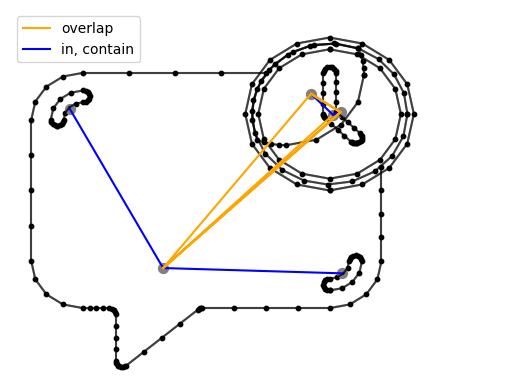

In [9]:
# plot edge
from matplotlib.lines import Line2D

tab20 = [plt.cm.tab20(x) for x in range(20)]

fig = plt.figure("plot_graph")
ax = fig.add_subplot(1, 1, 1)
plt.axis("off")
plt.axis([0, 28, 23, 0])

color_i = 0
for node in G_close.nodes:  
    # subgraph - nodes
    xx, yy = G_close.nodes[node]['features']['v'][:,0], G_close.nodes[node]['features']['v'][:,1]
    plt.scatter(xx, yy, color='black', s=10)
    # subgraph - edges
    max_len = len(G_close.nodes[node]['features']['v'])
    for p1, p2 in G_close.nodes[node]['features']['e']:
        x1, y1 = G_close.nodes[node]['features']['v'][p1,0], G_close.nodes[node]['features']['v'][p1,1]
        x2, y2 = G_close.nodes[node]['features']['v'][p2,0], G_close.nodes[node]['features']['v'][p2,1]
        l = Line2D([x1,x2], [y1,y2], color='black', alpha=0.5)
        ax.add_line(l)
        
    # main graph - nodes
    x, y = G_close.nodes[node]['features']['pos'][0], G_close.nodes[node]['features']['pos'][1]
    plt.scatter(x, y, color='gray', s=50)
    color_i += 1
    
# main graph - edges
for p1, p2 in G_close.edges:
    x1, y1 = G_close.nodes[p1]['features']['pos']
    x2, y2 = G_close.nodes[p2]['features']['pos']
    label = edge_type[(p1, p2)]
    if label == 'contain':
        l = Line2D([x1,x2], [y1,y2], color='blue', label='in, contain')
    elif label == 'overlap':
        l = Line2D([x1,x2], [y1,y2], color='orange', label='overlap')
    elif label == 'adjacent':
        l = Line2D([x1,x2], [y1,y2], color='red', label='adjacent')
    ax.add_line(l)

from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
    
plt.show()
plt.close()

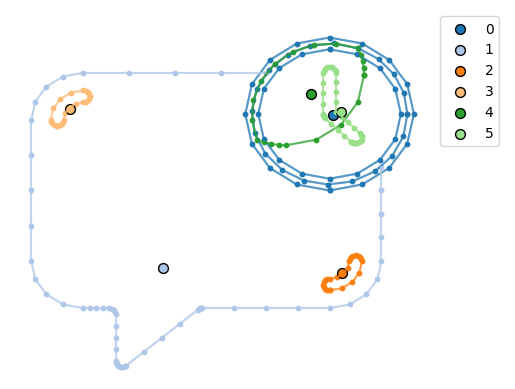

In [10]:
# plot graph
from matplotlib.lines import Line2D

tab20 = [plt.cm.tab20(x) for x in range(20)]

fig = plt.figure("plot_graph")
ax = fig.add_subplot(1, 1, 1)
plt.axis("off")
plt.axis([0, 28, 23, 0])

color_i = 0
for node in G_close.nodes:  
    # subgraph - nodes
    xx, yy = G_close.nodes[node]['features']['v'][:,0], G_close.nodes[node]['features']['v'][:,1]
    plt.scatter(xx, yy, color=tab20[color_i], s=10)
    
    # subgraph - edges
    for p1, p2 in G_close.nodes[node]['features']['e']:
        x1, y1 = G_close.nodes[node]['features']['v'][p1,0], G_close.nodes[node]['features']['v'][p1,1]
        x2, y2 = G_close.nodes[node]['features']['v'][p2,0], G_close.nodes[node]['features']['v'][p2,1]
        l = Line2D([x1,x2], [y1,y2], color=tab20[color_i], alpha=0.5)
        ax.add_line(l)
        
    # main graph - nodes
    x, y = G_close.nodes[node]['features']['pos'][0], G_close.nodes[node]['features']['pos'][1]
    plt.scatter(x, y, color=tab20[color_i], edgecolors='black', s=50, label=node)
    color_i += 1
    
# # main graph - edges
# for p1, p2 in G_close.edges:
#     x1, y1 = G_close.nodes[p1]['features']['pos']
#     x2, y2 = G_close.nodes[p2]['features']['pos']
#     l = Line2D([x1,x2], [y1,y2], color='black')
#     ax.add_line(l)

plt.legend()
plt.show()
plt.close()